# Try to look at the vessels in the delineated patches of the hearts
Ruslan/Tim delineated the patch region in the hearts.
Let's repeat what we did with the `Vessels.ipynb` notebook, but only for the delineated patch regions.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import pandas
import platform
import os
import glob
import numpy
import tqdm
from tqdm import notebook
from itkwidgets import view  # 3d viewer
import imageio
import skimage
import skimage.morphology
import scipy.stats
import dask
import dask.array as da
import dask_image.imread
from dask.distributed import Client
client = Client()
from numcodecs import Blosc

In [2]:
print('You can see what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can see what DASK is doing at "http://localhost:8787/status"


In [3]:
# Ignore warnings in the notebook
#import warnings
#warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [8]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version f0adc30 of the analyis notebook.


In [9]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

In [10]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Hearts Melly


In [11]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    tmp = os.path.join('F:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [12]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [13]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [14]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, 'Rat[67]*', '*'))

In [15]:
# Get some data from folders
Data['Sample'] = [os.path.basename(os.path.dirname(f)) for f in Data['Folder']]
Data['Scan'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(sn) for sn in Data['Sample']]
Data['ScanNameLength'] = [len(sn) for sn in Data['Scan']]

In [16]:
# From Ludovics mail
# R60/61 : W1, VP (VEGF + PDGF = both growth factors) 
# R62/63 : W1, F    (=fibrin only = empty patch)
# R64/65 : W1, Tachosil only (negative control)

# R66/68 : W4, VP (VEGF + PDGF = both growth factors) 
# R67/69 : W4, F    (=fibrin only = empty patch)
# R70/71 : W4, Tachosil only (negative control)

In [17]:
Data['Experiment'] = 'VP'
for c,row in Data.iterrows():
    # https://stackoverflow.com/a/3389611/323100
    if any(x in row.Sample for x in ['62', '63', '67', '69']):
        Data.at[c, 'Experiment'] = 'F'
    if any(x in row.Sample for x in ['64', '65', '70', '71']):
        Data.at[c, 'Experiment'] = 'Tachosil'

In [18]:
Data['Timepoint'] = 1
for c,row in Data.iterrows():
    # https://stackoverflow.com/a/3389611/323100
    if any(x in row.Sample for x in ['66', '68', '67', '69', '70', '71']):
        Data.at[c, 'Timepoint'] = 4

In [19]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
#exclude = [63, 65, 66, 70]

In [20]:
# Drop samples which should be excluded
# Based on https://stackoverflow.com/a/13851602
#for c,row in Data.iterrows():
#    for ex in exclude:
#        if str(ex) in row.Sample:
#            Data.drop(c, inplace=True)
#Data.reset_index(drop=True, inplace=True)

In [21]:
Data

,Folder,Sample,Scan,SampleNameLength,ScanNameLength,Experiment,Timepoint
0,F:\Hearts Melly\Rat60\overview,Rat60,overview,5,8,VP,1
1,F:\Hearts Melly\Rat61\overview,Rat61,overview,5,8,VP,1
2,F:\Hearts Melly\Rat62\overview,Rat62,overview,5,8,F,1
3,F:\Hearts Melly\Rat63\overview,Rat63,overview,5,8,F,1
4,F:\Hearts Melly\Rat64\overview,Rat64,overview,5,8,Tachosil,1
5,F:\Hearts Melly\Rat65\overview,Rat65,overview,5,8,Tachosil,1
6,F:\Hearts Melly\Rat66\overview,Rat66,overview,5,8,VP,4
7,F:\Hearts Melly\Rat67\overview,Rat67,overview,5,8,F,4
8,F:\Hearts Melly\Rat68\overview,Rat68,overview,5,8,VP,4
9,F:\Hearts Melly\Rat69\overview,Rat69,overview,5,8,F,4


In [22]:
# Get log files of all the scans scans
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]

In [23]:
# Tim delineated a *lot* of VOIs for each heart.
# He saved them with CTAn, so each get's a successive numbered voi folder (e.g. VOI(X)).
# Bruker doesn't use leading zeros. Nonetheless, we can just user a 'sorted'  list.
# And just use the last item of the list
Data['VOIFolders'] = [sorted(glob.glob(os.path.join(f, 'rec', 'VOI*'))) for f in Data['Folder']]
# If we didn't find a VOI folder, then just return empty
Data['VOIFolder'] = [f[-1] if f else [] for f in Data['VOIFolders']]

In [25]:
for c,row in Data.iterrows():
    if not len(row.VOIFolders):
        print('The patch of', row.Sample, 'needs to be delineated')

Rat67 is scanned badly, and has no identifiable patch.
Rat70 has an non-identifiable patch.

In [26]:
# Drop samples which have not been delineated yet
# Based on https://stackoverflow.com/a/13851602
Data = Data[Data['VOIFolder'].map(len) > 0]
Data.reset_index(drop=True, inplace=True)

In [27]:
Data

,Folder,Sample,Scan,SampleNameLength,ScanNameLength,Experiment,Timepoint,LogFile,VOIFolders,VOIFolder
0,F:\Hearts Melly\Rat60\overview,Rat60,overview,5,8,VP,1,F:\Hearts Melly\Rat60\overview\proj\Rat60.log,"[F:\Hearts Melly\Rat60\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat60\overview\rec\VOI(4)
1,F:\Hearts Melly\Rat61\overview,Rat61,overview,5,8,VP,1,F:\Hearts Melly\Rat61\overview\proj\Rat61.log,"[F:\Hearts Melly\Rat61\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat61\overview\rec\VOI(9)
2,F:\Hearts Melly\Rat62\overview,Rat62,overview,5,8,F,1,F:\Hearts Melly\Rat62\overview\proj\Rat62.log,"[F:\Hearts Melly\Rat62\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat62\overview\rec\VOI(2)
3,F:\Hearts Melly\Rat63\overview,Rat63,overview,5,8,F,1,F:\Hearts Melly\Rat63\overview\proj\Rat63.log,"[F:\Hearts Melly\Rat63\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat63\overview\rec\VOI(9)
4,F:\Hearts Melly\Rat64\overview,Rat64,overview,5,8,Tachosil,1,F:\Hearts Melly\Rat64\overview\proj\Rat64.log,"[F:\Hearts Melly\Rat64\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat64\overview\rec\VOI(5)
5,F:\Hearts Melly\Rat65\overview,Rat65,overview,5,8,Tachosil,1,F:\Hearts Melly\Rat65\overview\proj\Rat65.log,[F:\Hearts Melly\Rat65\overview\rec\VOI],F:\Hearts Melly\Rat65\overview\rec\VOI
6,F:\Hearts Melly\Rat66\overview,Rat66,overview,5,8,VP,4,F:\Hearts Melly\Rat66\overview\proj\Rat66.log,"[F:\Hearts Melly\Rat66\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat66\overview\rec\VOI(3)
7,F:\Hearts Melly\Rat67\overview,Rat67,overview,5,8,F,4,F:\Hearts Melly\Rat67\overview\proj\Rat67.log,[F:\Hearts Melly\Rat67\overview\rec\VOI],F:\Hearts Melly\Rat67\overview\rec\VOI
8,F:\Hearts Melly\Rat68\overview,Rat68,overview,5,8,VP,4,F:\Hearts Melly\Rat68\overview\proj\Rat68.log,"[F:\Hearts Melly\Rat68\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat68\overview\rec\VOI(3)
9,F:\Hearts Melly\Rat69\overview,Rat69,overview,5,8,F,4,F:\Hearts Melly\Rat69\overview\proj\Rat69.log,"[F:\Hearts Melly\Rat69\overview\rec\VOI, F:\He...",F:\Hearts Melly\Rat69\overview\rec\VOI(5)


In [28]:
# Get voxelsize from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [29]:
# Get the file names of the reconstructions
Data['VOISlices'] = [sorted(glob.glob(os.path.join(f, '*.png'))) for f in Data['VOIFolder']]
Data['Number of VOI slices'] = [len(r) for r in Data.VOISlices]

In [30]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %03s slices in its VOI folder in %s' % (c + 1,
                                                                   len(Data),
                                                                   row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                   row['Number of VOI slices'],
                                                                   row['VOIFolder']))

 1/12: Rat60 has 669 slices in its VOI folder in F:\Hearts Melly\Rat60\overview\rec\VOI(4)
 2/12: Rat61 has 796 slices in its VOI folder in F:\Hearts Melly\Rat61\overview\rec\VOI(9)
 3/12: Rat62 has 786 slices in its VOI folder in F:\Hearts Melly\Rat62\overview\rec\VOI(2)
 4/12: Rat63 has 629 slices in its VOI folder in F:\Hearts Melly\Rat63\overview\rec\VOI(9)
 5/12: Rat64 has 856 slices in its VOI folder in F:\Hearts Melly\Rat64\overview\rec\VOI(5)
 6/12: Rat65 has 750 slices in its VOI folder in F:\Hearts Melly\Rat65\overview\rec\VOI
 7/12: Rat66 has 864 slices in its VOI folder in F:\Hearts Melly\Rat66\overview\rec\VOI(3)
 8/12: Rat67 has 796 slices in its VOI folder in F:\Hearts Melly\Rat67\overview\rec\VOI
 9/12: Rat68 has 914 slices in its VOI folder in F:\Hearts Melly\Rat68\overview\rec\VOI(3)
10/12: Rat69 has 798 slices in its VOI folder in F:\Hearts Melly\Rat69\overview\rec\VOI(5)
11/12: Rat70 has 878 slices in its VOI folder in F:\Hearts Melly\Rat70\overview\rec\VOI
12/12: R

In [31]:
# Convert all VOI slices into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI'] = [os.path.join(f, sample + '_patch.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
Reconstructions = [numpy.nan for file in Data['OutputNameVOI']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameVOI']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameVOI'][len(Root):]))
    else:
        print('%2s/%s: Reading %s VOI slices from %s and saving to %s' % (c + 1,
                                                                          len(Data),
                                                                          row['Number of VOI slices'],
                                                                          row['VOIFolder'][len(Root):],
                                                                          row['OutputNameVOI'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['VOIFolder'], '*.png'))
        Reconstructions.to_zarr(row['OutputNameVOI'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

 1/12: Already saved to \Rat60\overview\Rat60_patch.zarr
 2/12: Already saved to \Rat61\overview\Rat61_patch.zarr
 3/12: Already saved to \Rat62\overview\Rat62_patch.zarr
 4/12: Already saved to \Rat63\overview\Rat63_patch.zarr
 5/12: Already saved to \Rat64\overview\Rat64_patch.zarr
 6/12: Already saved to \Rat65\overview\Rat65_patch.zarr
 7/12: Already saved to \Rat66\overview\Rat66_patch.zarr
 8/12: Already saved to \Rat67\overview\Rat67_patch.zarr
 9/12: Already saved to \Rat68\overview\Rat68_patch.zarr
10/12: Already saved to \Rat69\overview\Rat69_patch.zarr
11/12: Already saved to \Rat70\overview\Rat70_patch.zarr
12/12: Already saved to \Rat71\overview\Rat71_patch.zarr


In [32]:
# Load the reconstructions a zarr arrays
VOIs = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]

In [33]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in VOIs]

In [34]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [35]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Patch.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = VOIs[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c,'Mid_' + direction]).astype('uint8'))

In [36]:
# # Show middle slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['Mid_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' Middle slice'))
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png'),
#                 bbox_inches='tight')
#     plt.show()

In [37]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(VOIs)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Patch.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = VOIs[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

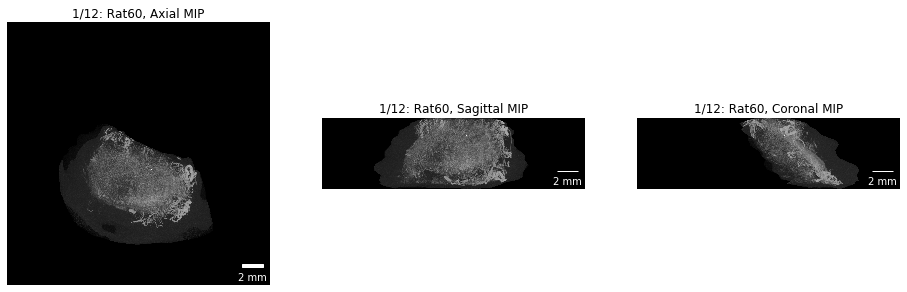

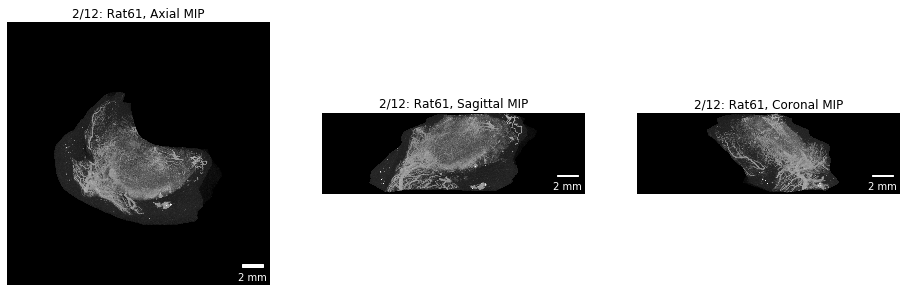

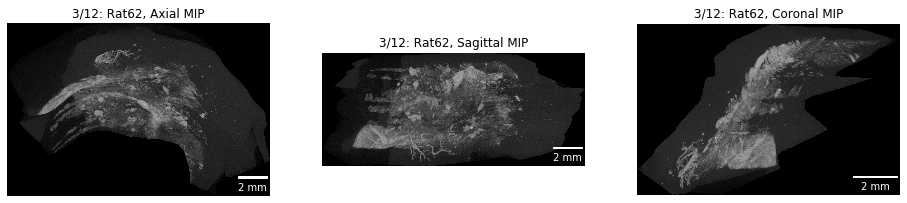

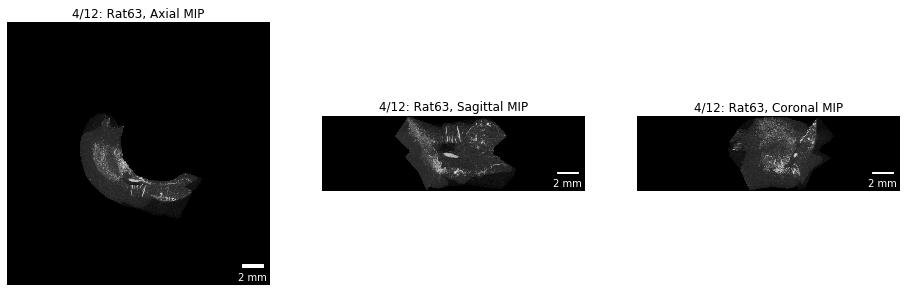

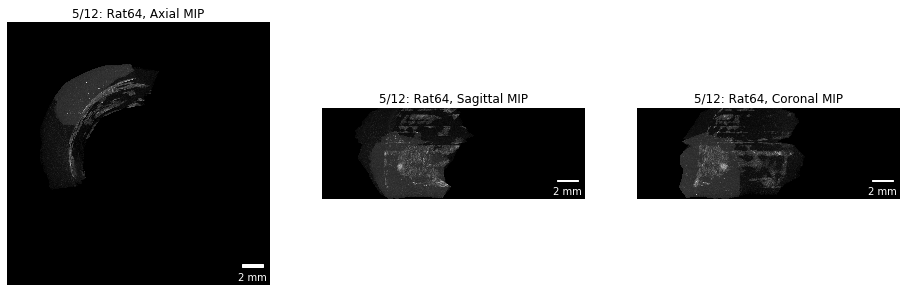

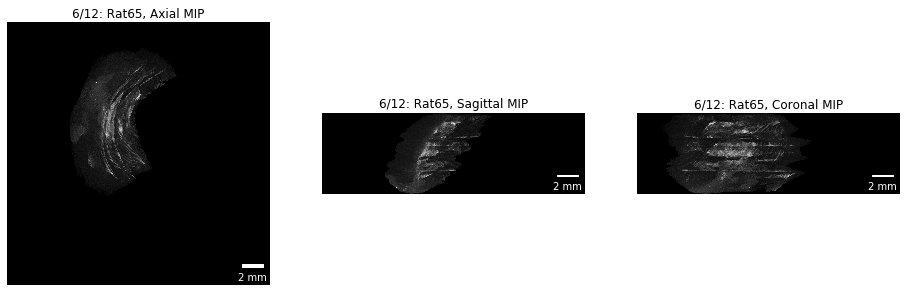

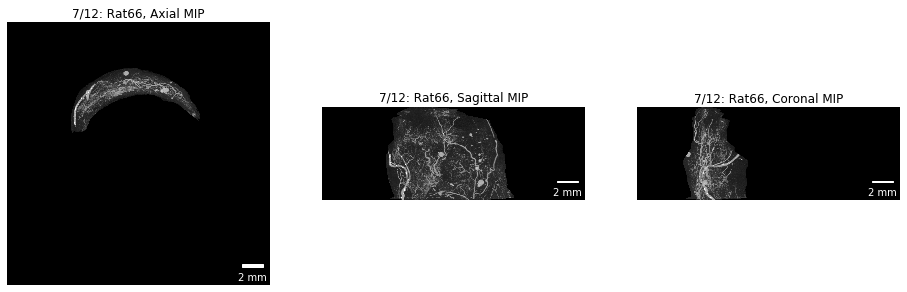

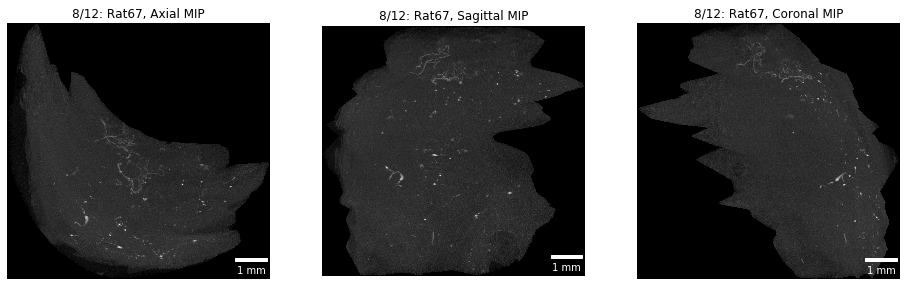

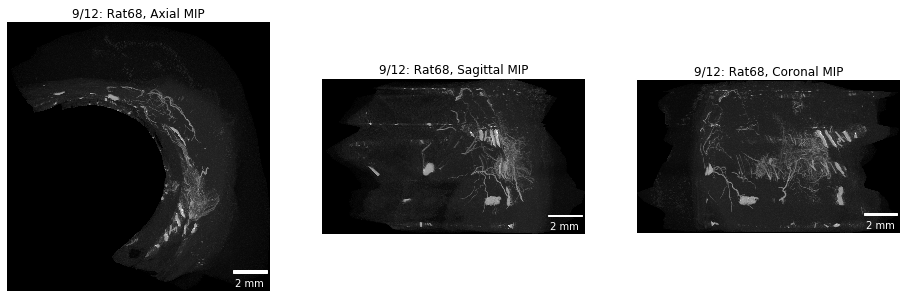

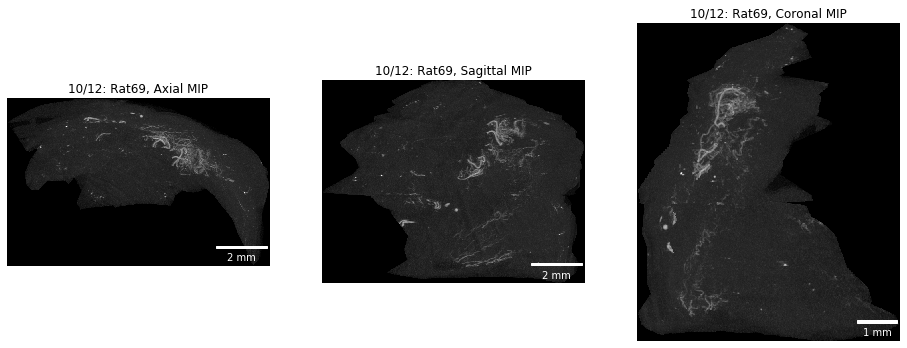

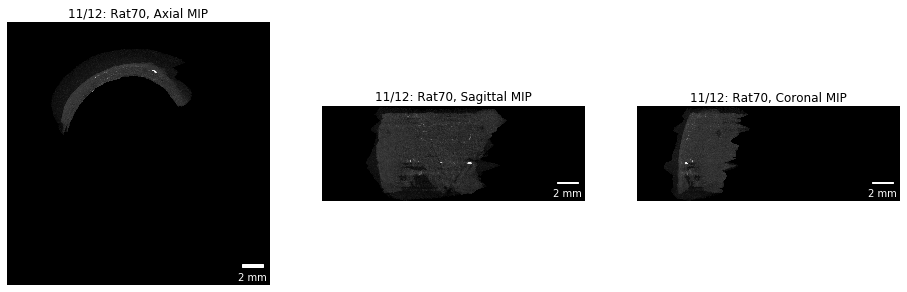

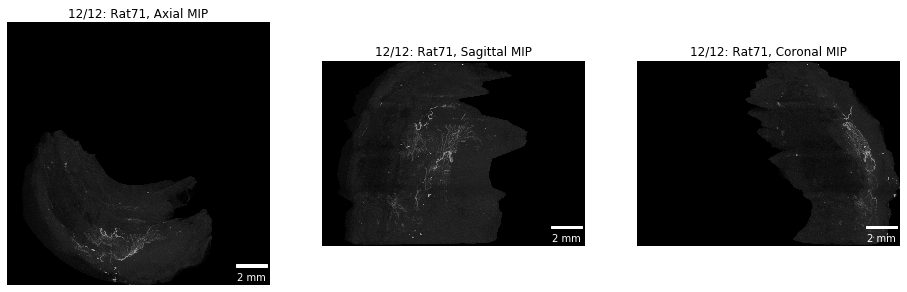

In [65]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
                bbox_inches='tight')
    plt.show()

The `mean` gray value needs to be calculated and 'calibrated' to the total volume of the ROI

In [38]:
# Mask the outside of the ROI that Tim drew
Masked = [da.ma.masked_equal(v, 0) for v in VOIs]

In [39]:
# How large are the VOIs from Tim?
# We select/mask everything non-zero and fill this whith one.
VOIRegion = [da.ma.filled(da.ma.masked_not_equal(v, 0), 1) for v in VOIs]
# By summing it, we get the volume
Data['VOIVolume'] = [vr.sum().compute() for vr in VOIRegion]

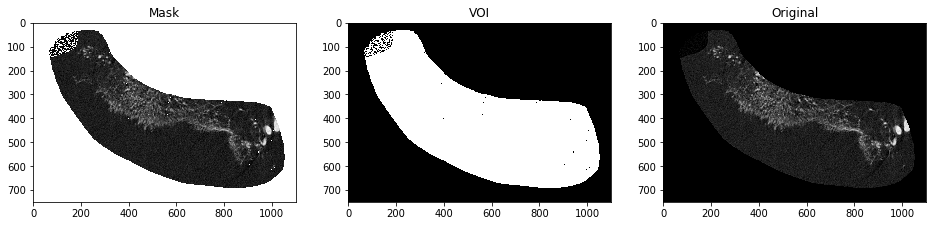

In [40]:
plt.subplot(131)
plt.imshow(Masked[0][100][950:1700,700:1800])
plt.title('Mask')
plt.subplot(132)
plt.imshow(VOIRegion[0][100][950:1700,700:1800])
plt.title('VOI')
plt.subplot(133)
plt.imshow(VOIs[0][100][950:1700,700:1800])
plt.title('Original')
plt.show()

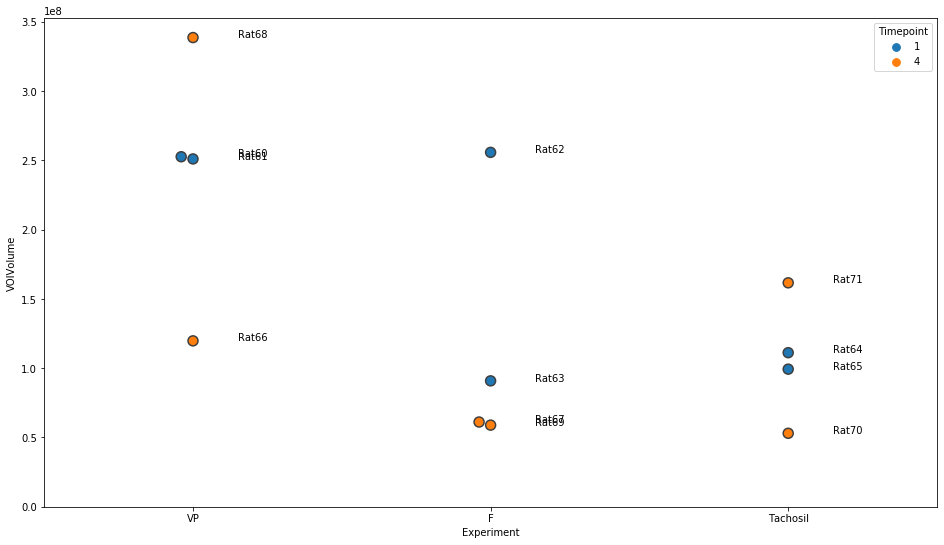

In [70]:
# Plot volume of VOIs for comparison
seaborn.swarmplot(data=Data, x='Experiment', y='VOIVolume', hue='Timepoint', s=10, linewidth=1.5)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0+.15, row.VOIVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1+.15, row.VOIVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2+.15, row.VOIVolume))
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.png'),
            bbox_inches='tight')
plt.show()

In [68]:
# Save mean of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueMean'] = [m.mean().compute() for m  in Masked]

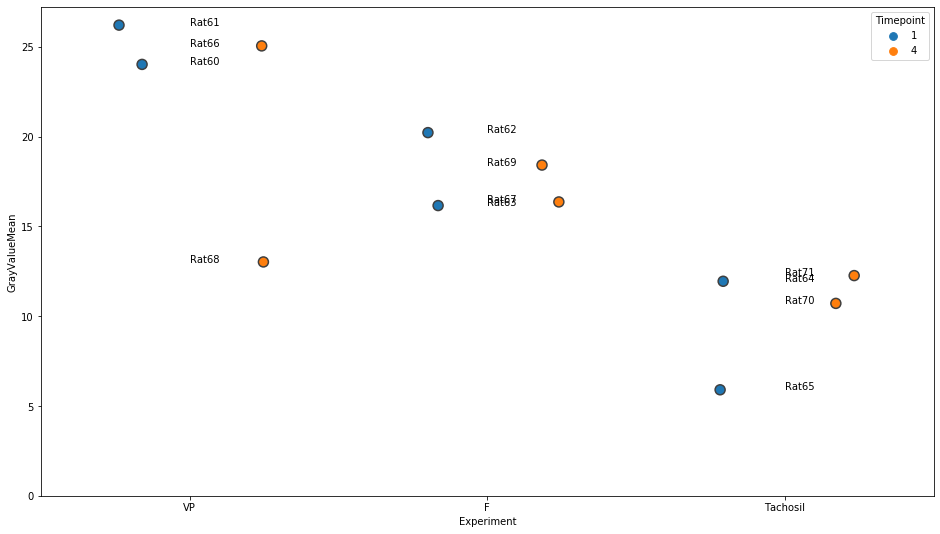

In [91]:
# Plot volume-normalized mean of datasets for comparison
seaborn.stripplot(data=Data, x='Experiment', y='GrayValueMean', hue='Timepoint', s=10, linewidth=1.5, dodge=True)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMean))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMean))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMean))
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.VOI.png'),
            bbox_inches='tight')
plt.show()

In [92]:
Data['GrayValueMeanNormalizedToVOIVolume'] = [numpy.divide(gvm,
                                                           vv) for gvm, vv in zip(Data['GrayValueMean'],
                                                                                  Data['VOIVolume'])]

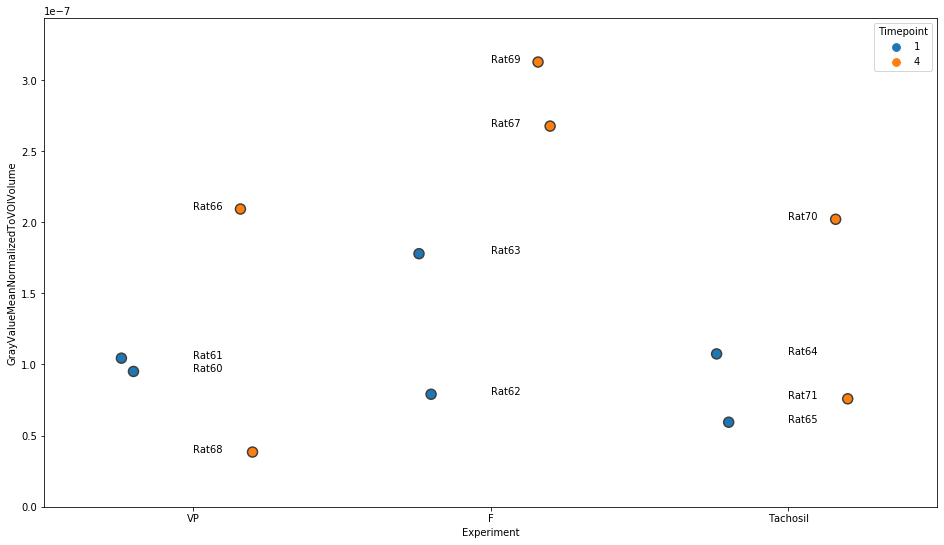

In [101]:
# Plot volume-normalized mean of datasets for comparison
#seaborn.boxplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToVOIVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToVOIVolume))
plt.ylim(ymin=0, ymax=1.1*Data.GrayValueMeanNormalizedToVOIVolume.max())
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedVOI.png'),
            bbox_inches='tight')
plt.show()

In [103]:
# # Save STD of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueSTD'] = [m.std().compute() for m in Masked]

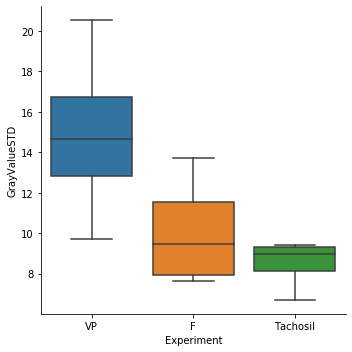

In [105]:
# # Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='GrayValueSTD')
# seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueSTD', linewidth=1.5, s=10, color='gray')
# plt.ylim(ymin=0)
# plt.show()

In [106]:
# def calculate_threshold(img, verbose=False):
#     '''
#     Calculate (Otsu) threshold of a stack, with some nice output if desired
#     '''
#     if len(numpy.shape(img)) != 3:
#         print('Only works with a 3D stack')
#         return()
#     if verbose:
#         print('The stack we use has a size of %s x %s x %s px' % numpy.shape(img))
#     threshold = skimage.filters.threshold_otsu(dask.array.ravel(img.compute()))
#     if verbose:
#         seaborn.distplot(img.ravel())
#         plt.axvline(threshold, label='Otsu@%s' % threshold, c=seaborn.color_palette()[1])
#         plt.axvline(numpy.mean(img), label='Image mean@%0.2f' % img.mean(), c=seaborn.color_palette()[2])
#         plt.legend()
#         plt.semilogy()
#         plt.xlim([0,255])
#         plt.show()
#     return(threshold.compute())

In [107]:
# # https://stackoverflow.com/a/38086839
# h,bins=dask.array.histogram(VOIs[0], bins=range(0,255,4))
# plt.semilogy(h)
# plt.show()

In [111]:
# Thresholds
preset = False
if preset:
    # Set them (from previous calculations)
    Data['Threshold'] = [41, 45, 41, 16, 12, 15, 63, 16, 13, 18, 13, 13]
    Data['Threshold'] = [41, 45, 41, 12, 13, 19, 13]
else:
    # Calculate Threshold
    Data['Threshold'] = [skimage.filters.threshold_otsu(
        dask.array.ravel(
            dask.array.ma.masked_less(
                rec, 1).compute())) for rec in VOIs]

In [112]:
list(Data.Threshold)

[41, 45, 41, 16, 12, 15, 63, 16, 13, 18, 13, 13]

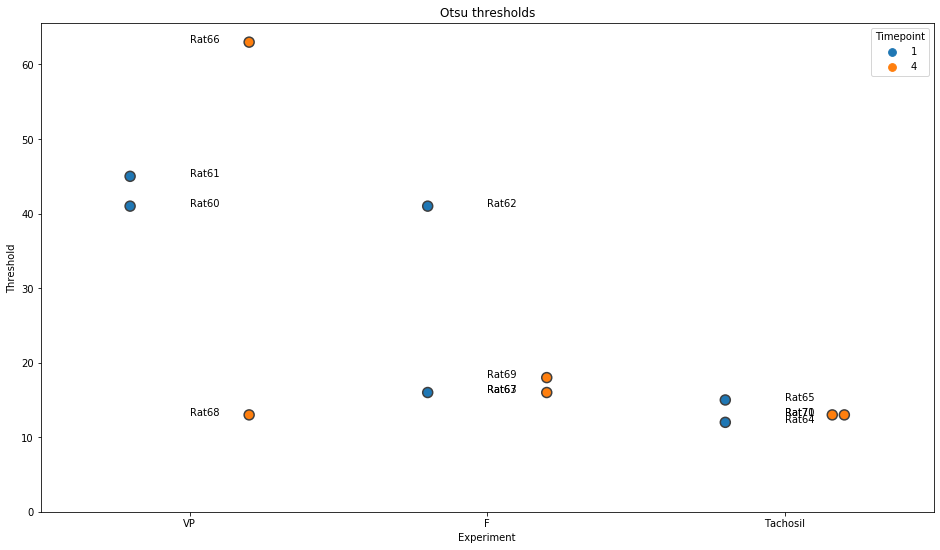

The mean threshold of all samples is 25.50


In [113]:
# Plot the thresholds
seaborn.swarmplot(data=Data, x='Experiment', y='Threshold', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.Threshold))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.Threshold))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.Threshold))
plt.ylim(ymin=0)
plt.title('Otsu thresholds')
plt.savefig(os.path.join(OutputDir, 'Thresholds.png'),
            bbox_inches='tight')
plt.show()
print('The mean threshold of all samples is %0.2f' % Data['Threshold'].mean())

In [114]:
# Get the mean threshold of all samples
Data['ThresholdMean'] = int(numpy.mean(Data['Threshold'].mean()))

In [115]:
# Threshold the reconstructions                                                                                                                            Data.Sample)
Data['OutputNameThresholded'] = [f.replace('.zarr', '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOI'], Data['Threshold'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholded'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = VOIs[c] > row['Threshold']
        Thresholded.to_zarr(row['OutputNameThresholded'],
                           overwrite=True,
                           compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))    

 1/12: Already saved to \Rat60\overview\Rat60_patch_thresholded_041.zarr
 2/12: Already saved to \Rat61\overview\Rat61_patch_thresholded_045.zarr
 3/12: Already saved to \Rat62\overview\Rat62_patch_thresholded_041.zarr
 4/12: Already saved to \Rat63\overview\Rat63_patch_thresholded_016.zarr
 5/12: Already saved to \Rat64\overview\Rat64_patch_thresholded_012.zarr
 6/12: Already saved to \Rat65\overview\Rat65_patch_thresholded_015.zarr
 7/12: Already saved to \Rat66\overview\Rat66_patch_thresholded_063.zarr
 8/12: Already saved to \Rat67\overview\Rat67_patch_thresholded_016.zarr
 9/12: Already saved to \Rat68\overview\Rat68_patch_thresholded_013.zarr
10/12: Already saved to \Rat69\overview\Rat69_patch_thresholded_018.zarr
11/12: Already saved to \Rat70\overview\Rat70_patch_thresholded_013.zarr
12/12: Already saved to \Rat71\overview\Rat71_patch_thresholded_013.zarr


In [116]:
# Load the DASK arrays of the thresholded samples
Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholded']]

In [88]:
# DASK
# Read or calculate the middle slices of the thresholded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle thresholded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Middle.%s.png' % (row['Sample'],
                                                                         row['Threshold'],
                                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Thresholded_Mid_' + direction] = Thresholded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Thresholded_Mid_' + direction].astype('uint8')*255))

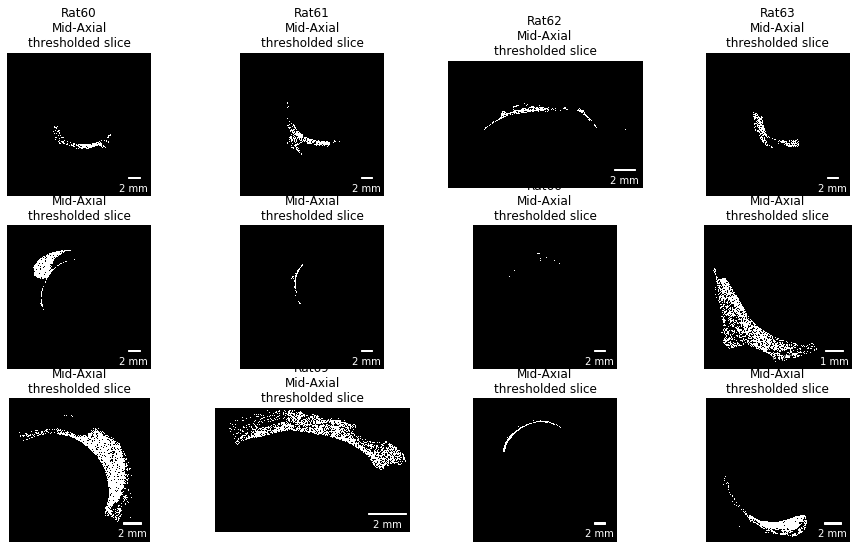

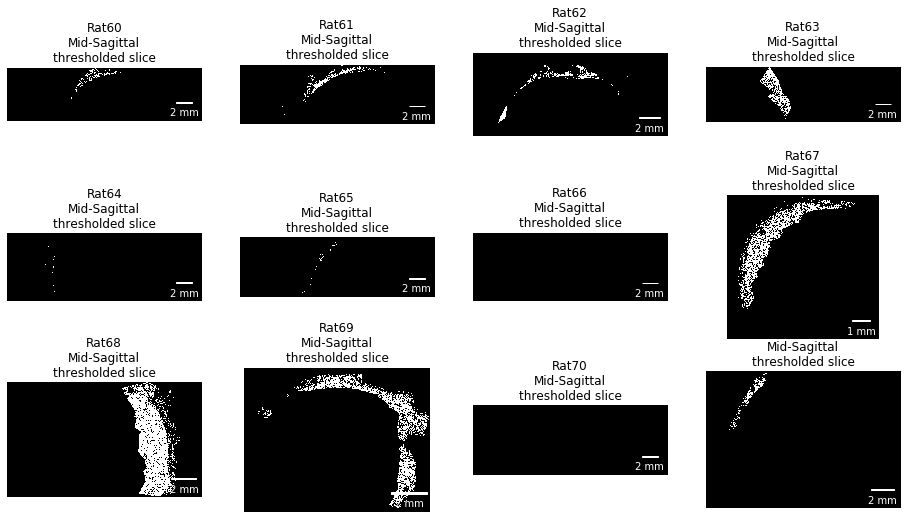

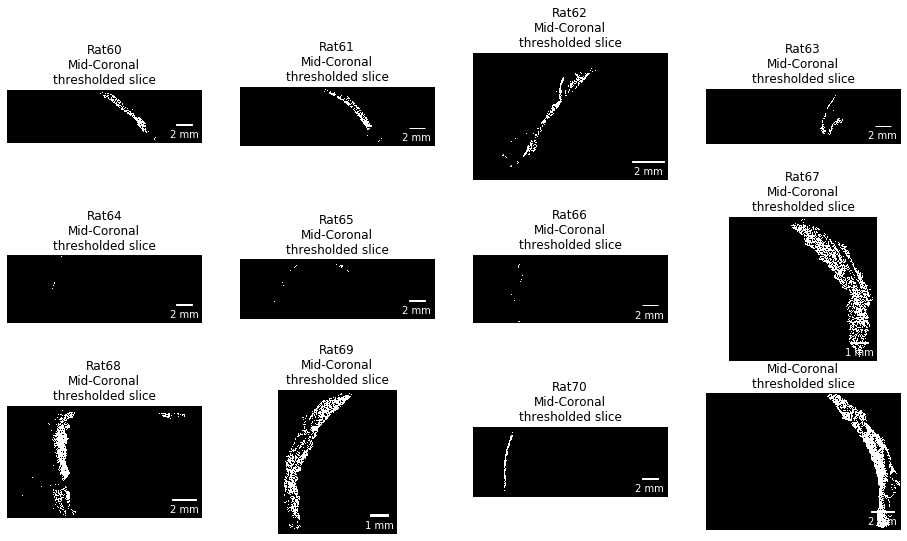

In [89]:
for d, direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Thresholded_Mid_' + direction])
        plt.title('%s\nMid-%s\nthresholded slice' % (row['Sample'], direction))
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))    
        plt.axis('off')
    plt.show()

In [90]:
# # Show MIP slices
# for c, row in Data.iterrows():
#     for d, direction in enumerate(directions):
#         plt.subplot(1, 3, d + 1)
#         plt.imshow(row['MIP_' + direction])
#         plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
#         plt.axis('off')
#     plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
#                 bbox_inches='tight')
#     plt.show()

In [117]:
# Sum the images, so we can see if they contain approximately the same *thresholded* volume
Data['ThresholdedVolume'] = [th.sum().compute() for th in Thresholded]

In [92]:
# Data[['Sample', 'ThresholdedVolume']]

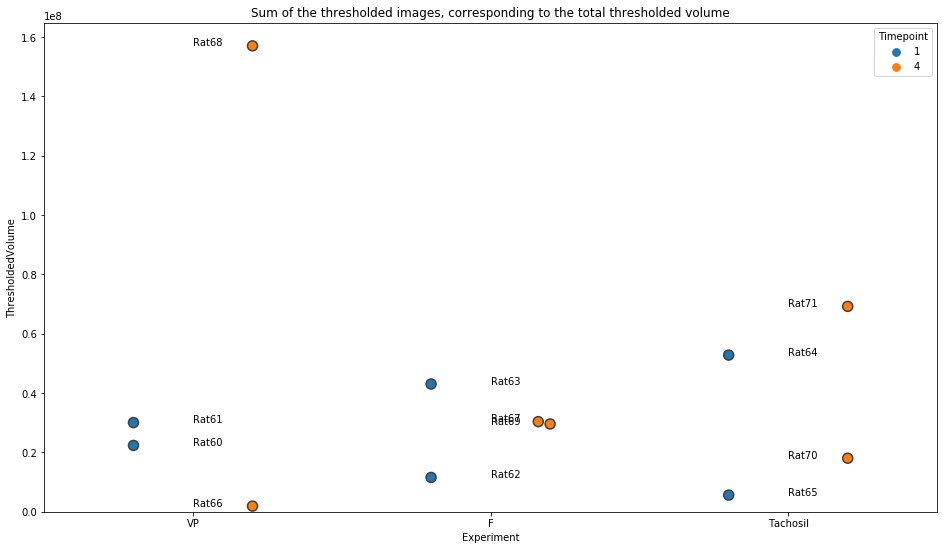

In [123]:
# Plot the thresholded volumes
seaborn.swarmplot(data=Data, x='Experiment', y='ThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.ThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.ThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.ThresholdedVolume))
plt.ylim(ymin=0)
plt.title('Sum of the thresholded images, corresponding to the total thresholded volume')
plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.png'),
            bbox_inches='tight')
plt.show()

In [124]:
Data[['Sample', 'Experiment', 'Threshold', 'ThresholdedVolume', 'GrayValueMean']]

,Sample,Experiment,Threshold,ThresholdedVolume,GrayValueMean
0,Rat60,VP,41,22376633,24.022819
1,Rat61,VP,45,30071830,26.210212
2,Rat62,F,41,11589236,20.223584
3,Rat63,F,16,43079926,16.161328
4,Rat64,Tachosil,12,52826778,11.946263
5,Rat65,Tachosil,15,5635816,5.902991
6,Rat66,VP,63,1916137,25.053420
7,Rat67,F,16,30392929,16.364150
8,Rat68,VP,13,157064852,13.022539
9,Rat69,F,18,29618068,18.417467


In [125]:
Data['GrayValueMeanNormalizedToThresholdedVolume'] = [numpy.divide(gvm,
                                                                   tv) for gvm, tv in zip(Data['GrayValueMean'],
                                                                                          Data['ThresholdedVolume'])]

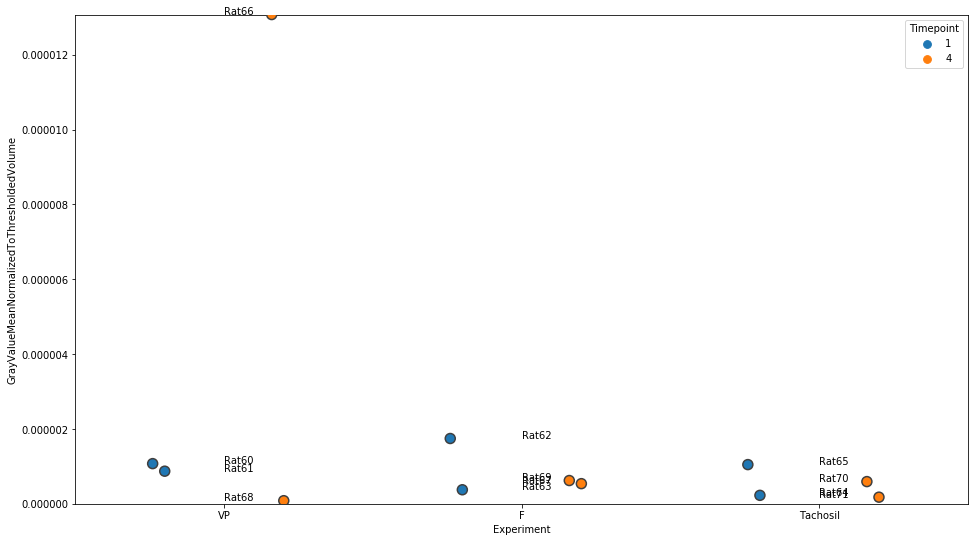

In [130]:
# Plot volume-normalized mean of datasets for comparison
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
plt.ylim(ymin=0, ymax=Data.GrayValueMeanNormalizedToThresholdedVolume.max())
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.png'),
            bbox_inches='tight')
plt.show()

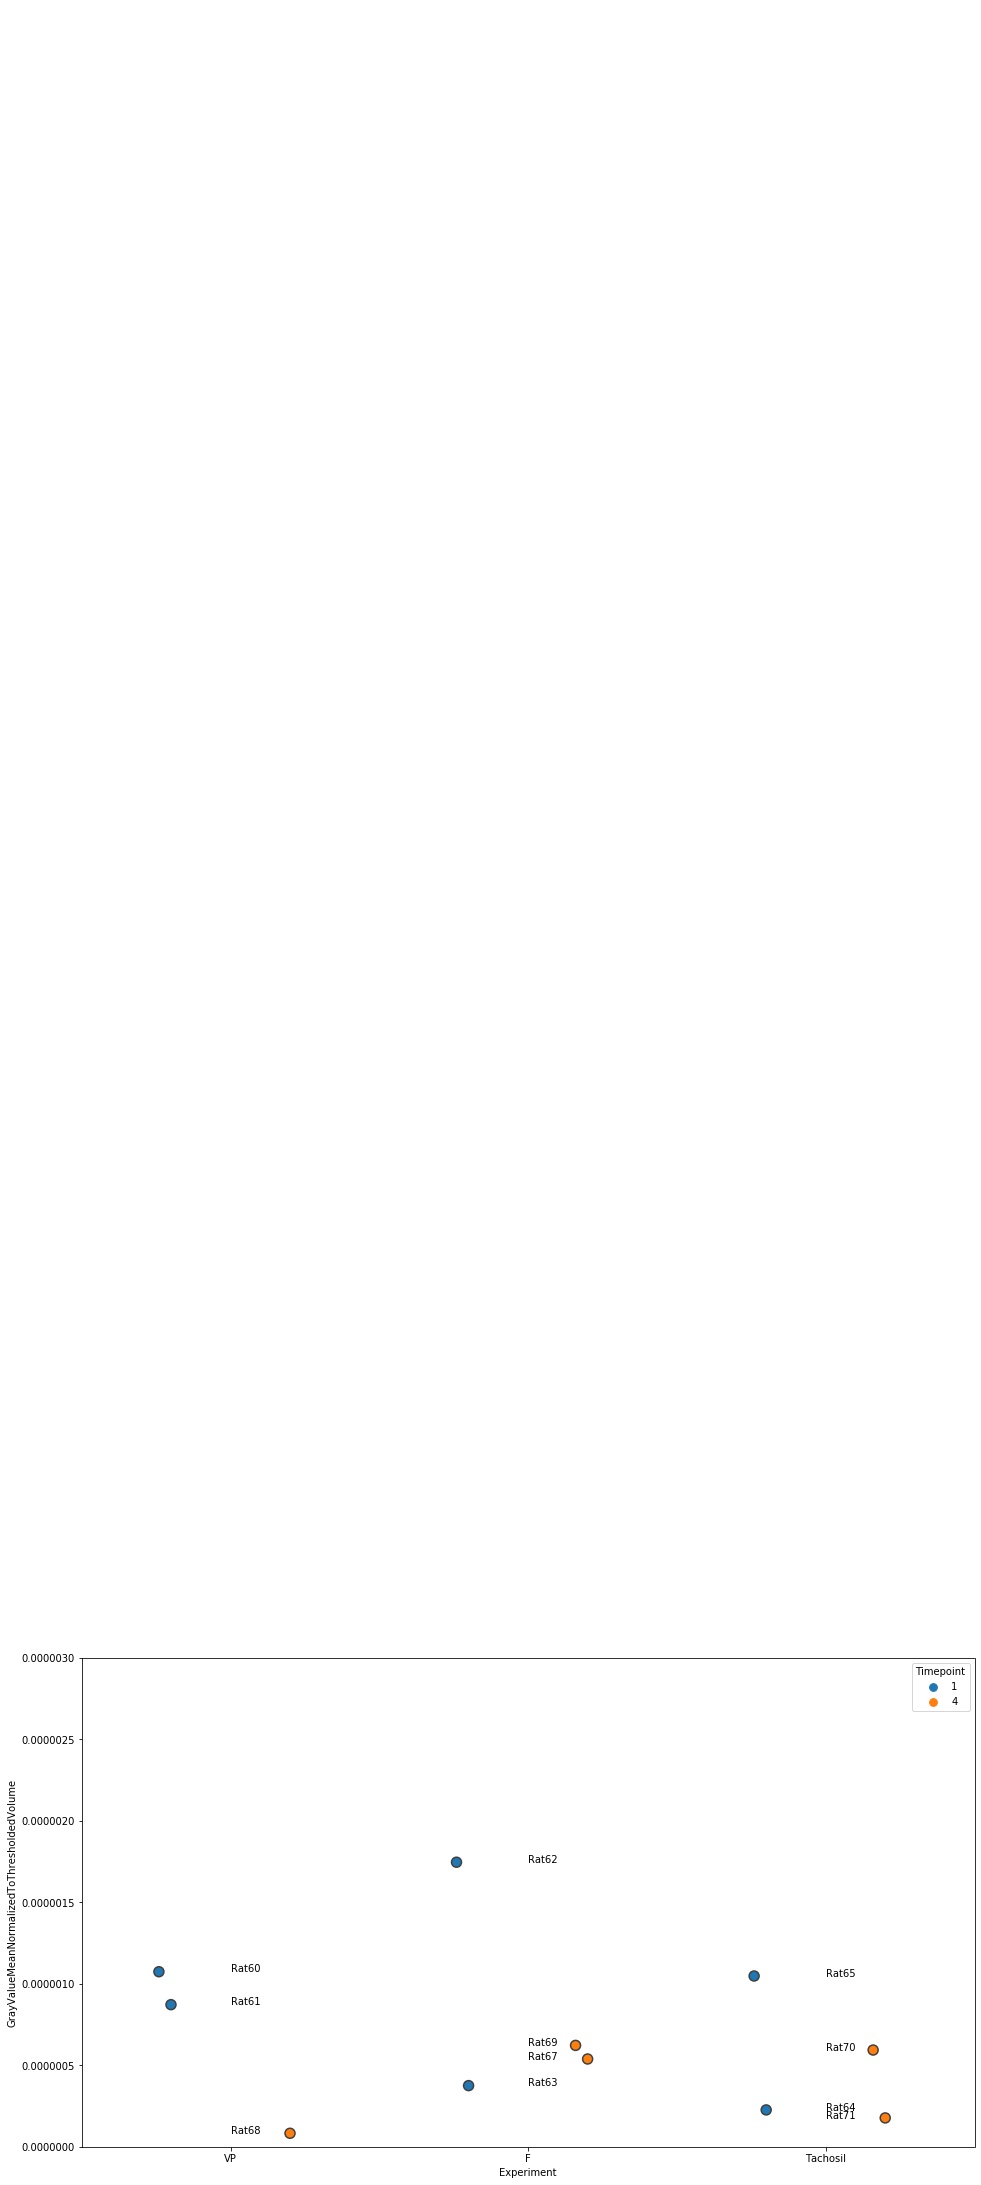

In [132]:
# Plot volume-normalized mean of datasets for comparison
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.GrayValueMeanNormalizedToThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.GrayValueMeanNormalizedToThresholdedVolume))
plt.ylim(ymin=0, ymax=0.000003)
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedToThresholded.Without66.png'),
            bbox_inches='tight')
plt.show()

In [122]:
# view(Thresholded[0].compute().astype('uint8'))

# Characterization of vessel diameter
- Fill the vessels/ventricle (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the big stuff with `tophat`
- Calculate the distance-transformation or skeleton

In [100]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    Thanks to `tqdm_notebook` we also get a progress bar...
    And afterwards generate an output array.
    '''
    filled = [skimage.morphology.remove_small_holes(s, area_threshold=1e4) for
              s in tqdm.notebook.tqdm(image, leave=False)]
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('Filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('Overlay')        
        plt.show()    
    return(filled)

In [101]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [102]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [103]:
# Calculate the flood-filled image
# Since this takes a while, we don't do it in a Pythonic way
# e.g. (Flooded = [ourfiller(t, verbose=True) for t in Tresholded])
# but in a loop with saving in between.
Data['OutputNameFlooded'] = [f.replace('.zarr', '_flooded.zarr') for f in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameFlooded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameFlooded'][len(Root):]))
    else:
        print('%2s/%s: %s: Filling holes' % (c + 1,
                                             len(Data),
                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        Flooded = ourfiller(Thresholded[c].compute())
        Flooded = da.stack(Flooded[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                     row['OutputNameFlooded'][len(Root):]))
        Flooded.to_zarr(row['OutputNameFlooded'],
                        overwrite=True,
                        compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

 1/12: Already saved to \Rat60\overview\Rat60_patch_thresholded_041_flooded.zarr
 2/12: Already saved to \Rat61\overview\Rat61_patch_thresholded_045_flooded.zarr
 3/12: Already saved to \Rat62\overview\Rat62_patch_thresholded_041_flooded.zarr
 4/12: Rat63: Filling holes


      Rat63: Saving to \Rat63\overview\Rat63_patch_thresholded_016_flooded.zarr
 5/12: Already saved to \Rat64\overview\Rat64_patch_thresholded_012_flooded.zarr
 6/12: Rat65: Filling holes


      Rat65: Saving to \Rat65\overview\Rat65_patch_thresholded_015_flooded.zarr
 7/12: Rat66: Filling holes


      Rat66: Saving to \Rat66\overview\Rat66_patch_thresholded_063_flooded.zarr
 8/12: Rat67: Filling holes


      Rat67: Saving to \Rat67\overview\Rat67_patch_thresholded_016_flooded.zarr
 9/12: Already saved to \Rat68\overview\Rat68_patch_thresholded_013_flooded.zarr
10/12: Rat69: Filling holes


      Rat69: Saving to \Rat69\overview\Rat69_patch_thresholded_018_flooded.zarr
11/12: Rat70: Filling holes


      Rat70: Saving to \Rat70\overview\Rat70_patch_thresholded_013_flooded.zarr
12/12: Rat71: Filling holes


      Rat71: Saving to \Rat71\overview\Rat71_patch_thresholded_013_flooded.zarr


In [104]:
# Load the DASK arrays with the filled samples
Flooded = [dask.array.from_zarr(file) for file in Data['OutputNameFlooded']]

In [105]:
# DASK
# Read or calculate the middle slices of the flooded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Flooded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle flooded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Flooded.Middle.%s.png' % (row['Sample'],
                                                                                 row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Flooded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,
                            (Data.at[c,'Flooded_Mid_' + direction].astype('uint8')*255))

In [106]:
# plt.imshow(Data['Thresholded_Mid_Axial'][0])
# plt.imshow(dask.array.ma.masked_less(Data['Flooded_Mid_Axial'][0], 1), alpha=0.5, cmap='viridis')

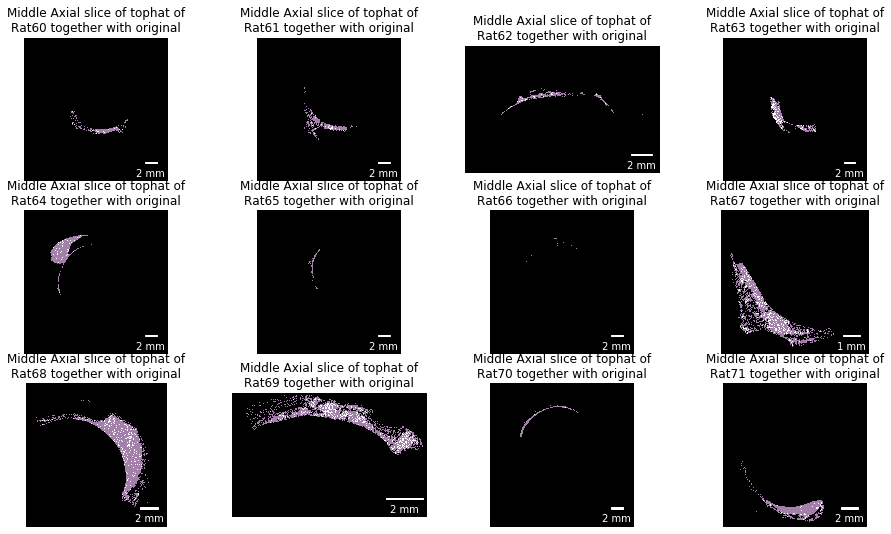

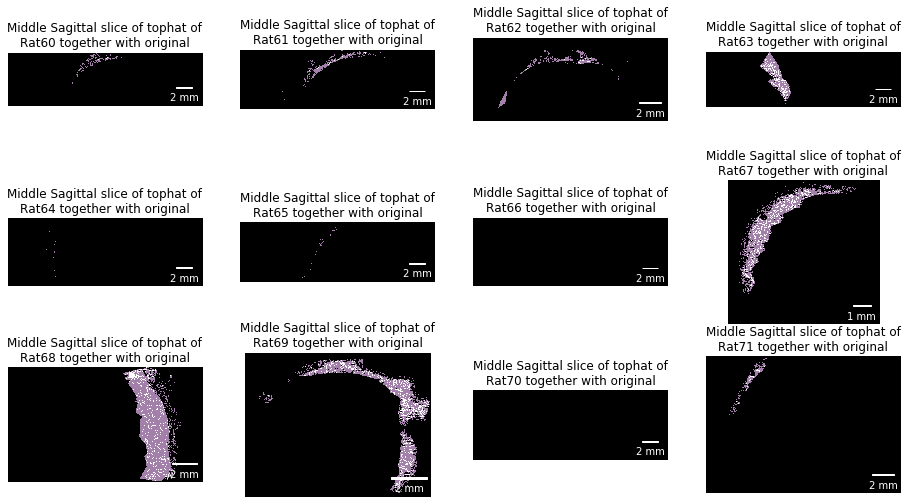

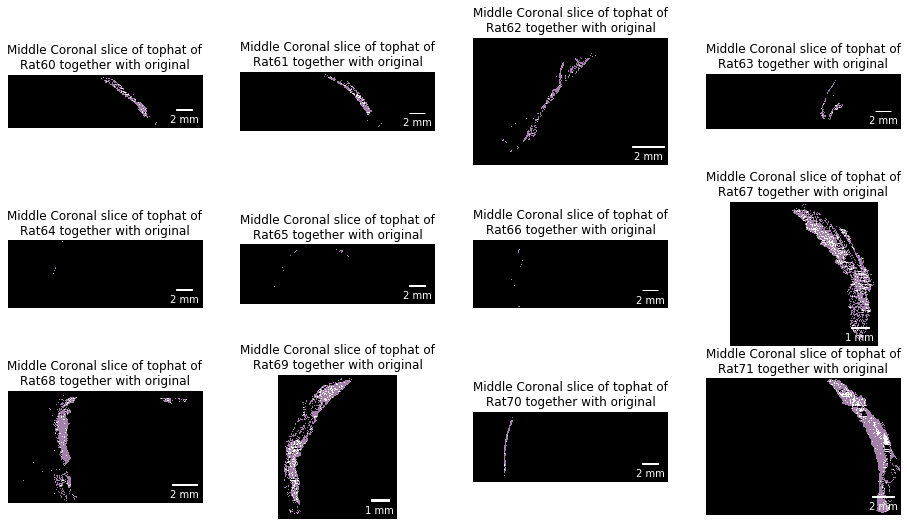

In [107]:
# Show middle axis flooded images
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [108]:
# plt.subplot(121)
# plt.imshow(Data['Thresholded_Mid_' + direction][1])
# plt.subplot(122)
# plt.imshow(Data['Flooded_Mid_' + direction][1])

In [109]:
Flooded[0]

,Array,Chunk
Bytes,4.02 GB,6.01 MB
Shape,"(669, 2452, 2452)","(1, 2452, 2452)"
Count,670 Tasks,669 Chunks
Type,bool,numpy.ndarray


In [110]:
Reconstructions[0]

dask.array<getitem, shape=(2452, 2452), dtype=uint8, chunksize=(2452, 2452), chunktype=numpy.ndarray>

In [111]:
# Get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
# Again, since this takes a *long* while, we don't do it nice and pythonic,
# but in a loop with intermediate saving
# e.g. not (Tophat = [skimage.morphology.white_tophat(f, selem=skimage.morphology.ball(7)) for f in Flooded])
# but
tophatselem = 5
Data['OutputNameTophat'] = [f.replace('.zarr', '_tophat_%s.zarr' % tophatselem) for f in Data['OutputNameFlooded']]
Tophat = [numpy.nan for file in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameTophat']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameTophat'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating white thophat with a "selem" of %s' % (c + 1,
                                                                              len(Data),
                                                                              row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                              tophatselem))
        Tophat = skimage.morphology.white_tophat(Flooded[c].compute(),
                                                 selem=skimage.morphology.ball(tophatselem))
        Tophat = da.stack(Tophat[:])        
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                      row['OutputNameTophat'][len(Root):]))
        Tophat.to_zarr(row['OutputNameTophat'],
                       overwrite=True,
                       compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

 1/12: Already saved to \Rat60\overview\Rat60_patch_thresholded_041_flooded_tophat_5.zarr
 2/12: Already saved to \Rat61\overview\Rat61_patch_thresholded_045_flooded_tophat_5.zarr
 3/12: Already saved to \Rat62\overview\Rat62_patch_thresholded_041_flooded_tophat_5.zarr
 4/12: Rat63: Calculating white thophat with a "selem" of 5
      Rat63: Saving to \Rat63\overview\Rat63_patch_thresholded_016_flooded_tophat_5.zarr
 5/12: Already saved to \Rat64\overview\Rat64_patch_thresholded_012_flooded_tophat_5.zarr
 6/12: Rat65: Calculating white thophat with a "selem" of 5
      Rat65: Saving to \Rat65\overview\Rat65_patch_thresholded_015_flooded_tophat_5.zarr
 7/12: Rat66: Calculating white thophat with a "selem" of 5
      Rat66: Saving to \Rat66\overview\Rat66_patch_thresholded_063_flooded_tophat_5.zarr
 8/12: Rat67: Calculating white thophat with a "selem" of 5
      Rat67: Saving to \Rat67\overview\Rat67_patch_thresholded_016_flooded_tophat_5.zarr
 9/12: Already saved to \Rat68\overview\Rat6

In [112]:
#img = Thresholded[1][1250:-1350,100:-100,100:-100].compute()

In [113]:
# 2D
#tophat = skimage.morphology.white_tophat(a, selem=skimage.morphology.disk(33))

In [114]:
# 2D
#plt.subplot(131)
#plt.imshow(a)
#plt.subplot(132)
#plt.imshow(tophat)
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(a,
#                             tophat), alpha=0.5)
#plt.imshow(tophat, cmap='viridis', alpha=0.5)
#plt.show()

In [115]:
# Calculate 3D topat
#tophat = skimage.morphology.white_tophat(img, selem=skimage.morphology.ball(11))

In [116]:
#whichslice = numpy.shape(img)[0]//2
#plt.subplot(131)
#plt.imshow(img[whichslice])
#plt.subplot(132)
#plt.imshow(tophat[whichslice])
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(img[whichslice],
#                             tophat[whichslice]), alpha=0.5)
#plt.imshow(tophat[whichslice], cmap='viridis', alpha=0.5)

In [117]:
# Load the DASK arrays with the tophat-filtered samples (e.g. only containing the smaller vessels)
Tophat = [dask.array.from_zarr(file) for file in Data['OutputNameTophat']]

In [118]:
# DASK
# Read or calculate the middle slices of the Tophat images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Tophat_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle tophat images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Tophat.Middle.%s.png' % (row['Sample'],
                                                                                row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Tophat_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Tophat_Mid_' + direction].astype('uint8')*255))

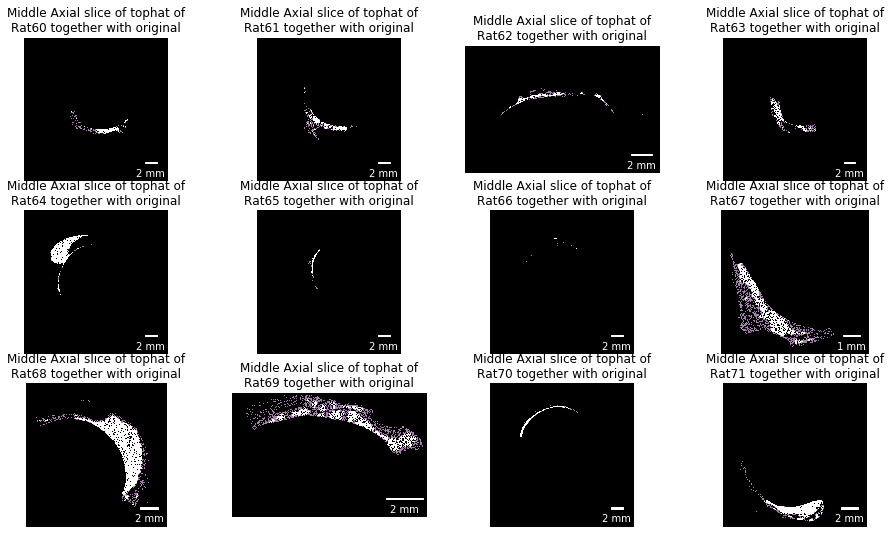

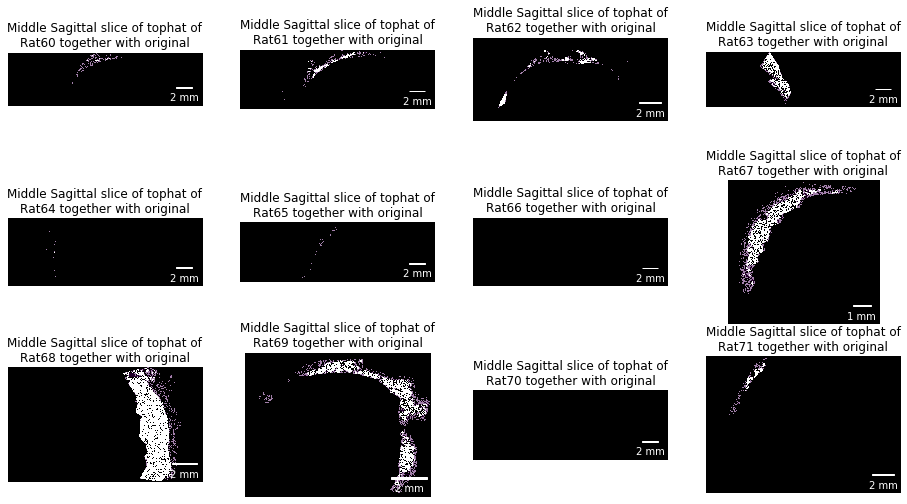

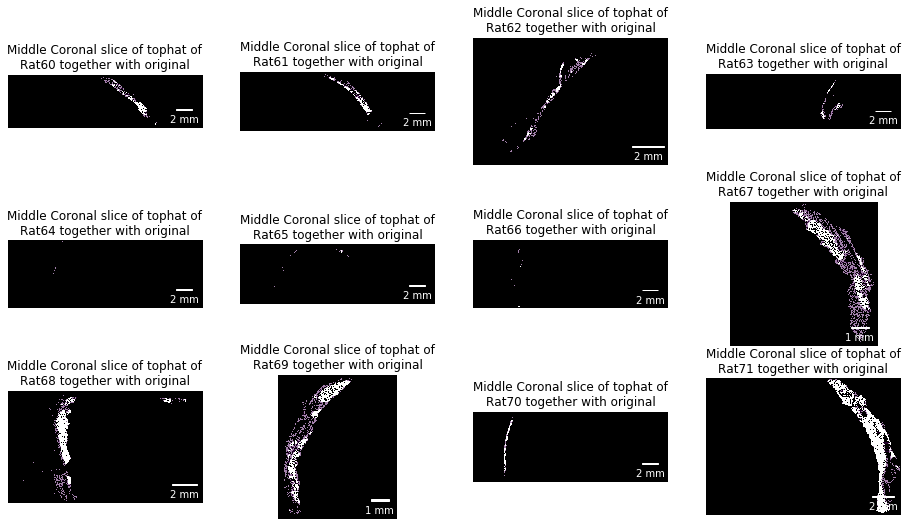

In [119]:
# Show middle slices of tophat data
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Thresholded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Tophat_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [120]:
# Show overlay
# for c, direction in enumerate(directions):
#     print(c, direction)    
#     if c:
#         plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     else:
#         plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
#     plt.axis('off')
#     plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
#     plt.show()

In [121]:
# Calculate the skeletonization
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
Data['OutputNameSkeleton'] = [f.replace('.zarr', '_skeleton.zarr') for f in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkeleton']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkeleton'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating skeletonization' % (c + 1,
                                                           len(Data),
                                                           row['Sample'].rjust(Data['SampleNameLength'].max())))
        Skeleton = skimage.morphology.skeletonize_3d(Tophat[c])
        Skeleton = da.stack(Skeleton[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                     row['OutputNameSkeleton'][len(Root):]))
        Skeleton.to_zarr(row['OutputNameSkeleton'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

 1/12: Already saved to \Rat60\overview\Rat60_patch_thresholded_041_flooded_tophat_5_skeleton.zarr
 2/12: Already saved to \Rat61\overview\Rat61_patch_thresholded_045_flooded_tophat_5_skeleton.zarr
 3/12: Already saved to \Rat62\overview\Rat62_patch_thresholded_041_flooded_tophat_5_skeleton.zarr
 4/12: Rat63: Calculating skeletonization
      Rat63: Saving to \Rat63\overview\Rat63_patch_thresholded_016_flooded_tophat_5_skeleton.zarr
 5/12: Already saved to \Rat64\overview\Rat64_patch_thresholded_012_flooded_tophat_5_skeleton.zarr
 6/12: Rat65: Calculating skeletonization
      Rat65: Saving to \Rat65\overview\Rat65_patch_thresholded_015_flooded_tophat_5_skeleton.zarr
 7/12: Rat66: Calculating skeletonization
      Rat66: Saving to \Rat66\overview\Rat66_patch_thresholded_063_flooded_tophat_5_skeleton.zarr
 8/12: Rat67: Calculating skeletonization
      Rat67: Saving to \Rat67\overview\Rat67_patch_thresholded_016_flooded_tophat_5_skeleton.zarr
 9/12: Already saved to \Rat68\overview\Rat6

In [122]:
# Load the DASK arrays with the skeletonized images
Skeleton = [dask.array.from_zarr(file) for file in Data['OutputNameSkeleton']]

In [123]:
# Read or calculate the middle slices of the Skeletonization images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Skeleton_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle skeleton images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.Skeleton.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Skeleton_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, Data.at[c,'Skeleton_Mid_' + direction].astype('uint8'))

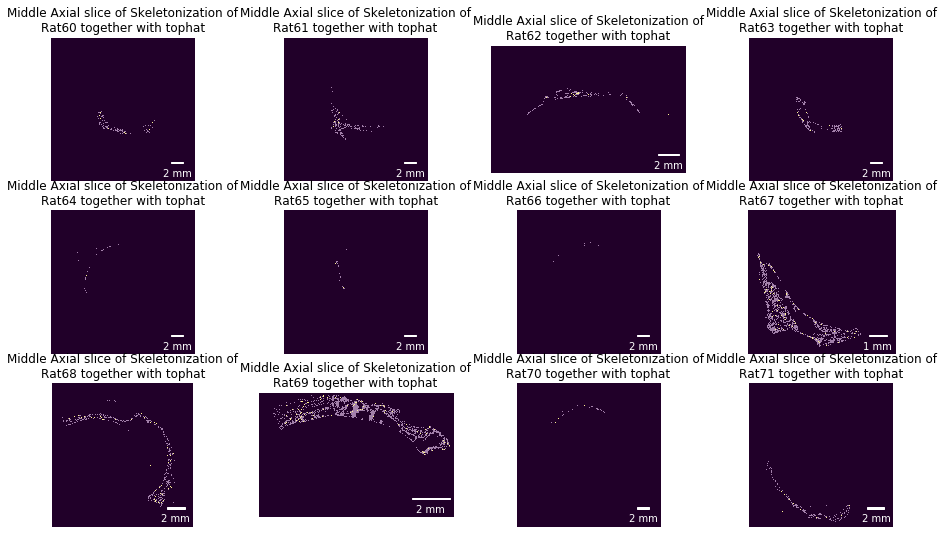

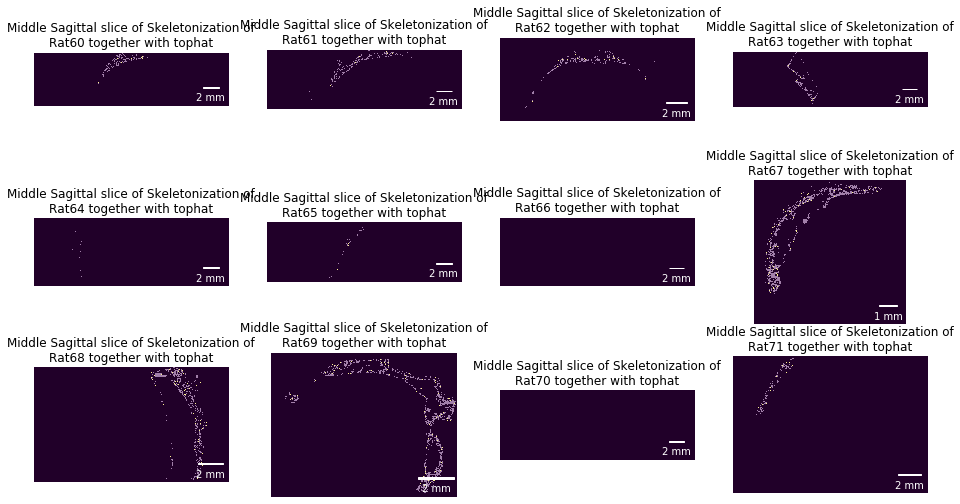

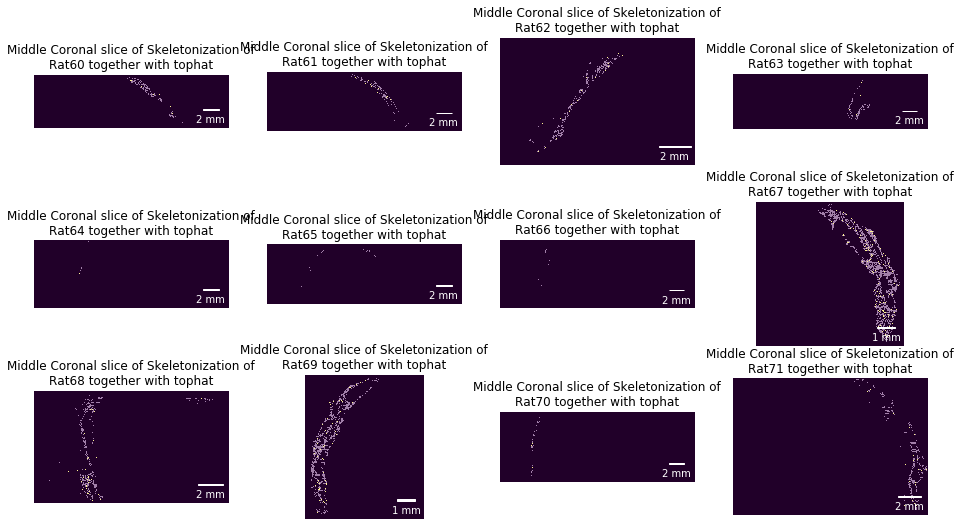

In [124]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(row['Skeleton_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of Skeletonization of\n%s together with tophat' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [125]:
#a, b = scipy.ndimage.morphology.distance_transform_edt(Tophat[0][900:1000], sampling=10)

In [126]:
#numpy.shape(a)

In [127]:
#plt.imshow(a[5])

In [128]:
#Tophat[0][800:-800,800:-800,800:-800]

In [129]:
Tophat[1]

,Array,Chunk
Bytes,4.50 GB,6.01 MB
Shape,"(748, 2452, 2452)","(1, 2452, 2452)"
Count,749 Tasks,748 Chunks
Type,bool,numpy.ndarray


In [ ]:
# Calculate the euclidean distance transformation
subsampling = 5
Data['OutputNameEDT'] = [f.replace('.zarr', '_edt_sampling%s.zarr' % subsampling) for f in Data['OutputNameTophat']]
# Calculate EDT
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameEDT']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameEDT'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating euclidean distance transformation' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        EDT = scipy.ndimage.morphology.distance_transform_edt(Tophat[c].astype('bool'),
                                                              sampling=subsampling)
        EDT = da.stack(EDT[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                      row['OutputNameEDT']))
        EDT.to_zarr(row['OutputNameEDT'],
                    overwrite=True,
                    compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

 1/12: Already saved to \Rat60\overview\Rat60_patch_thresholded_041_flooded_tophat_5_edt_sampling5.zarr
 2/12: Rat61: Calculating euclidean distance transformation


In [ ]:
# Load in the EDT from the saved zarr files   
EDT = [dask.array.from_zarr(file) for file in Data['OutputNameEDT']]

In [ ]:
# DASK
# Read or calculate the middle slices of the EDT images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['EDT_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle EDT images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.EDT.Middle.%s.png' % (row['Sample'],
                                                                             row['Threshold'],
                                                                             direction))
        if os.path.exists(outfilepath):
            Data.at[c,'EDT_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'EDT_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Calculate distance on skeleton
Data['OutputNameSkelDist'] = [f.replace('.zarr', '_skeletondistance.zarr') for f in Data['OutputNameTophat']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkelDist']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkelDist'][len(Root):]))
    else:
        print('%2s/%s: %s: Multiplying skeleton and EDT and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                             row['OutputNameSkelDist'][len(Root):]))
        SkelDist = numpy.multiply(Skeleton[c], EDT[c])
        SkelDist.to_zarr(row['OutputNameSkelDist'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load the DASK arrays with the skeleton-distance
SkelDist = [dask.array.from_zarr(file) for file in Data['OutputNameSkelDist']]

In [ ]:
# DASK
# Read or calculate the middle slices of the SkelDist images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['SkelDist_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle SkelDist images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.SkelDist.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'SkelDist_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'SkelDist_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.imshow(dask.array.ma.masked_where(0, row['EDT_Mid_' + direction]), alpha=0.5, cmap='viridis')
        plt.imshow(row['SkelDist_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of SkelDist of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
#EDT[6].max().compute()

In [ ]:
sl = 999
plt.subplot(131)
plt.imshow(numpy.max(Skeleton[0], axis=0), cmap='viridis')
plt.subplot(132)
plt.imshow(numpy.max(EDT[0], axis=0), cmap='viridis')
plt.subplot(133)
plt.imshow(numpy.max(SkelDist[0], axis=0), cmap='viridis')
plt.show()

In [ ]:
# Read or calculate skeletondistance MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_SkelDist_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='MIPs SkelDist', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'],
                                   '%s.Thresholded%03d.MIP.SkelDist.%s.png' % (row['Sample'],
                                                                               row['Threshold'],
                                                                               direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_SkelDist_' + direction] = imageio.imread(outfilepath)
        else:
            # Keep *this* reconstruction in RAM for a bit
            img = SkelDist[c].astype('uint8').persist()
            # Generate MIP
            Data.at[c,'MIP_SkelDist_' + direction] = img.max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath,
                            Data.at[c,'MIP_SkelDist_' + direction])

In [ ]:
for i, row in Data.iterrows():
    for j, direction in enumerate(directions):
        plt.subplot(1,3,j+1)
#         plt.imshow(row['MIP_' + direction], alpha=0.5)
#         plt.imshow(dask.array.ma.masked_less(row['MIP_SkelDist_' + direction],1), cmap='viridis')        
        plt.imshow(row['MIP_SkelDist_' + direction], cmap='viridis')            
        plt.title('%s view' % direction)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))                
        plt.axis('off')        
    plt.suptitle('%02d/%02d: MIP with Skeleton overlay %s' % (i+1, len(Data), row['Sample']))
    plt.show()

In [ ]:
SkelDist[0].max().compute()

In [ ]:
Data['SkelDistMean'] = [dask.array.mean(skldst).compute() for skldst in SkelDist]

In [ ]:
Data.head()

In [ ]:
Data['SkelDistMeanNormalized'] = [dask.array.mean(skldst).compute()/tv for skldst, tv in zip(SkelDist, Data['ThresholdedVolume'])]

In [ ]:
Data['SkelDistSTD'] = [dask.array.std(skldst).compute() for skldst in SkelDist]

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMean')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance.png'))
plt.show()

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMeanNormalized')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMeanNormalized', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value, normalized to thresholded volume')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_Normalized.png'))
plt.show()

In [ ]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistSTD')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Skeleton distance STD')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_STD.png'))
plt.show()